In [1]:
main_dir = '/Users/simon/fbso/fbso/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

In [2]:
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath


In [4]:
salt_nc = xr.open_dataset(salt)
theta_nc = xr.open_dataset(theta)
big_nc = xr.merge([salt_nc, theta_nc]).isel(time=42)
both_nc = big_nc.where(big_nc.coords['Depth']!=0).drop(['iter', 'Depth', 'rA', 'drF', 'hFacC'])
big_nc

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 588, Z: 52)
Coordinates:
    iter     int64 78518
    time     datetime64[ns] 2011-08-01T15:12:00
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.98265 -77.9479 -77.91305 ... -29.870987 -29.715317
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4799.915 4800.0 4736.8916
    rA       (YC, XC) float32 14884064.0 14884064.0 ... 292099870.0 292099870.0
    drF      (Z) float32 4.2 5.0 5.9 6.9 8.5 ... 400.0 400.0 400.0 400.0 400.0
    hFacC    (Z, YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    SALT     (Z, YC, XC) float32 ...
    THETA    (Z, YC, XC) float32 ...

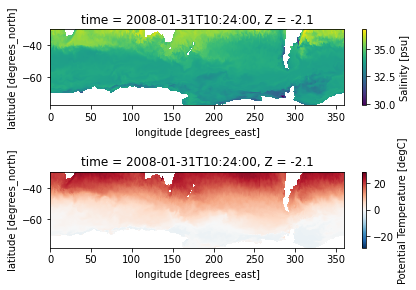

In [5]:
def plot_both(time_i=0):
    fig, axs = plt.subplots(2, 1)
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth']!=0).drop(['iter', 'Depth', 'rA', 'drF', 'hFacC'])
    both_nc.SALT.isel(Z=0).plot(ax=axs[0])
    both_nc.THETA.isel(Z=0).plot(ax=axs[1])
    plt.tight_layout()

plot_both()

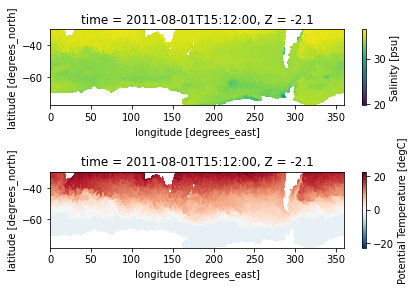

In [6]:
plot_both(time_i=42)


In [98]:
import pyxpcm
from pyxpcm.models import pcm

def pcm_fit(time_i=42, K=4):  
    # Define features to use
    # Instantiate the PCM
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > max_depth).drop(['iter', 'Depth', 'rA', 'drF', 'hFacC'])   
    ds = both_nc
    m = pcm(K=K, features=features_pcm, maxvar=2)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    ds.XC.attrs = both_nc.XC.attrs # There is some problem with attribute propogation in PyXCM
    ds.YC.attrs = both_nc.YC.attrs
    return ds, m


In [12]:
ds, m = pcm_fit()

In [71]:
#ds0 = ds.fillna(0)
#ds0.PCM_LABELS.encoding['_FillValue'] = False
#ds0.encoding['_FillValue'] = False

#ds0.to_netcdf('trial.nc', engine='h5netcdf')
ds.to_netcdf('trial.nc', engine='netcdf4')
ds
#ds0.PCM_LABELS.encoding

<xarray.Dataset>
Dimensions:     (XC: 2160, YC: 588, Z: 52)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * XC          (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC          (YC) float64 -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
Data variables:
    SALT        (Z, YC, XC) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 2.0 2.0 2.0 2.0 2.0

In [64]:
def output_trial_netcdf(time_i=42):
    max_depth=2000
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > max_depth).drop(['iter', 'Depth', 'rA', 'drF', 'hFacC'])
    ds1 = both_nc.fillna(0)
    #ds1.PCM_LABELS.encoding['_FillValue'] = False
    ds1.encoding['_FillValue'] = False
    ds1.to_netcdf('trial_no_label.nc', engine='netcdf4')
    both_nc.to_netcdf('trial_no_label_default_fill.nc', engine='netcdf4')
    return both_nc

both_nc = output_trial_netcdf()

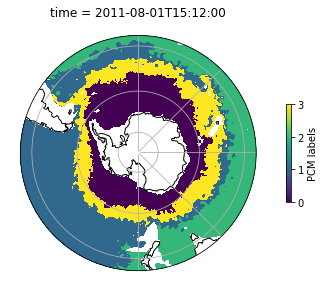

In [91]:
def plot_pcm_labels(xr_ds):

    map_proj = ccrs.SouthPolarStereo()
    carree = ccrs.PlateCarree()

    fig = plt.figure(figsize=[5, 5])

    ax1 = plt.subplot(1, 1, 1, projection=map_proj)
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)
    ax1.set_extent([-180, 180, -90, -30], carree)
    
    def plot_boundary():
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.45
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax1.set_boundary(circle, transform=ax1.transAxes)
    
    plot_boundary()
    
    # 

    xr_ds.PCM_LABELS.plot(transform=carree,                      # the data's projection
                          ax=ax1,
                          subplot_kws={"projection": map_proj},  # the plot's projection
                          cbar_kwargs={"shrink": 0.3},
                          #levels=range(-0.5, 3.5, 1)
                          #vmin=0,
                          #vmax=3.1
                          )
    
    # ax1.update_datalim((-180, 180, -90, 90))

    ax1.coastlines()
    
    ax1.gridlines(xlocs=range(0, 361, 45), ylocs=range(-80, -19, 20))
    
    plt.show()
    

plot_pcm_labels(ds)


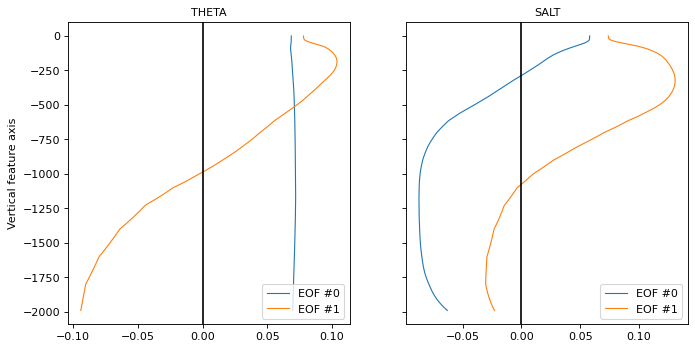

In [92]:
fig, ax = m.plot.reducer()


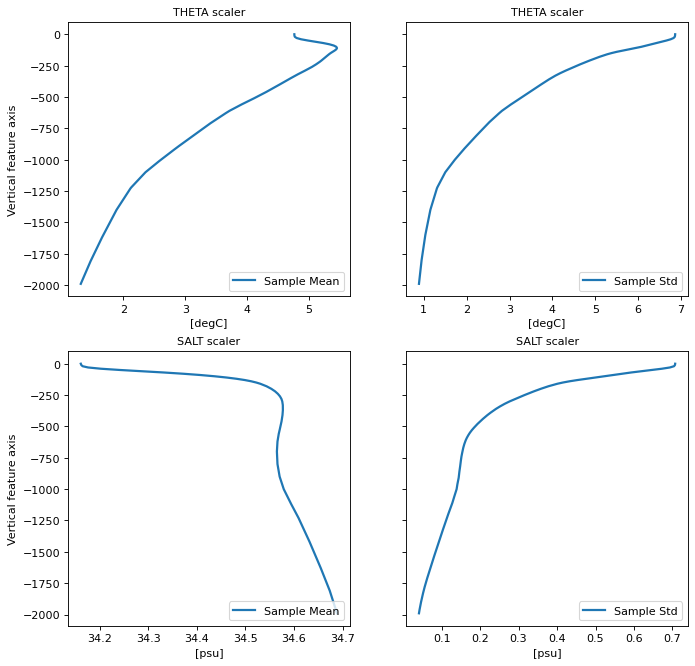

In [93]:
fig, ax = m.plot.scaler()


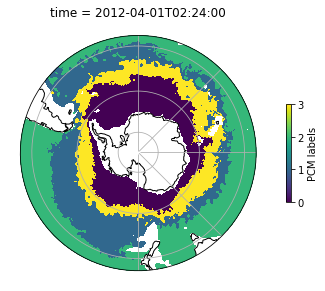

In [94]:
ds1, m1 = pcm_fit(time_i=50)
plot_pcm_labels(ds1)

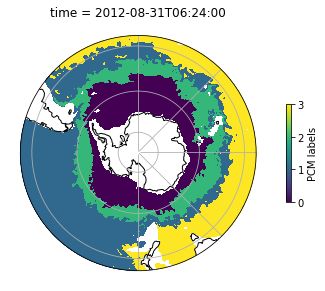

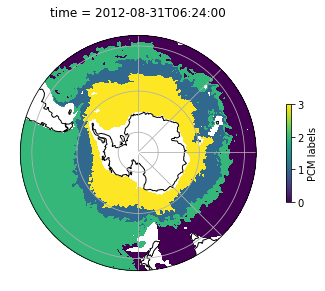

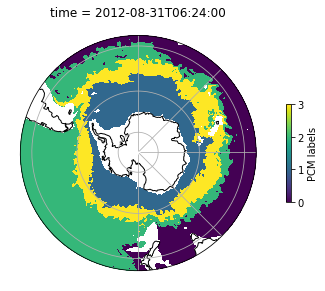

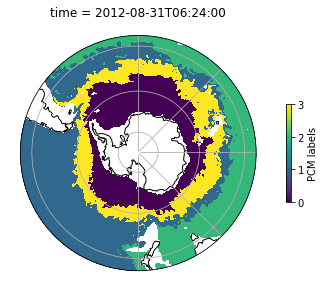

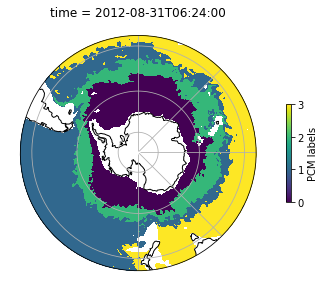

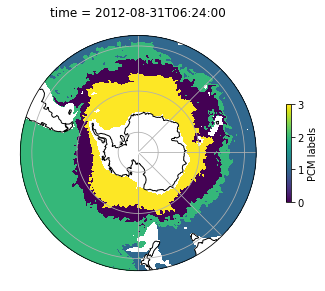

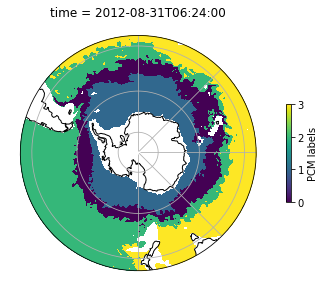

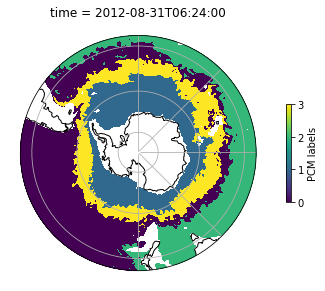

4min 38s ± 37.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%%timeit
ds2, m2 = pcm_fit(time_i=55)
plot_pcm_labels(ds2)


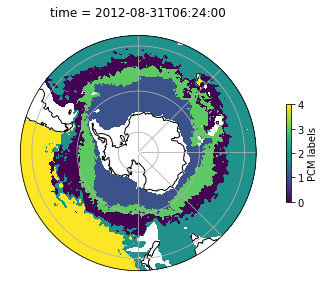

In [99]:
ds3, m3 = pcm_fit(time_i=55, K=5)
plot_pcm_labels(ds3)

In [103]:
m3.bic(ds3)

-888519.7448011059

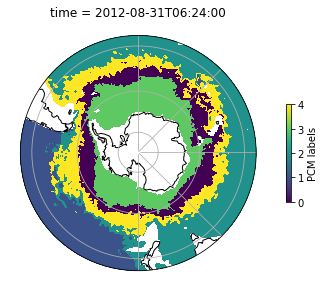

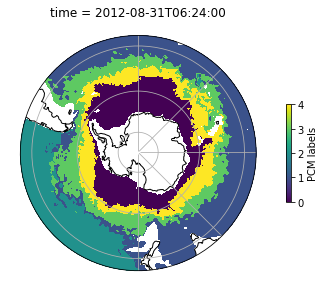

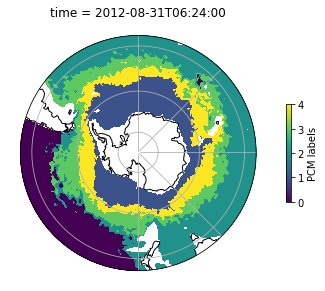

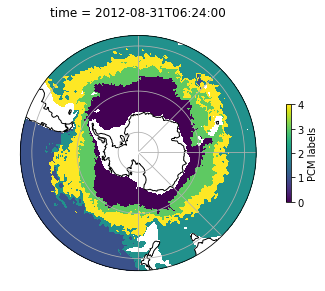

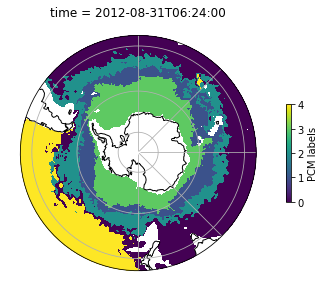

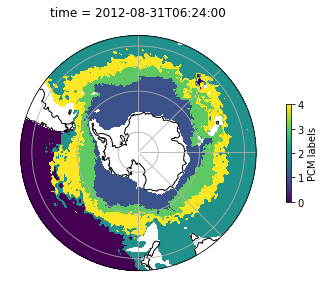

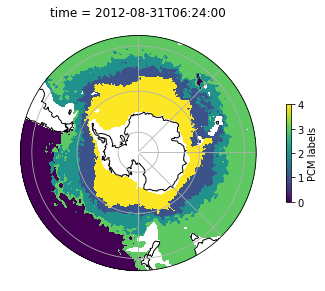

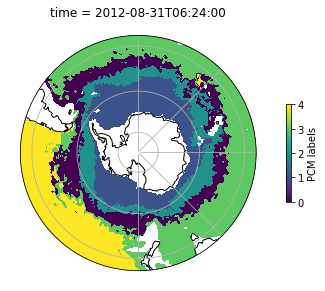

4min 43s ± 44.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
%%timeit
ds3, m3 = pcm_fit(time_i=55, K=5)
plot_pcm_labels(ds3)

In [151]:
import pyxpcm
from pyxpcm.models import pcm


def pcm_fit_and_post(time_i=42, K=4):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > max_depth).drop(['iter', 'Depth', 'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
            

    ds = both_nc # .copy(deep=True)
    m = pcm(K=K, features=features_pcm, maxvar=2)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    m.predict_proba(ds, features=features, dim='Z', inplace=True)
    
    def sanitize():
        #ds.XC.attrs = both_nc.XC.attrs # There is some problem with attribute propogation in PyXCM
        #ds.YC.attrs = both_nc.YC.attrs
        del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    return ds, m



In [152]:
ds4, m4 = pcm_fit_and_post(K=5)
# ds4.XC.attrs = both_nc.XC.attrs 
# There is some problem with attribute propogation in PyXCM
# ds4.YC.attrs = both_nc.YC.attrs
ds4.to_netcdf('trial_post_5.nc', engine='netcdf4')

In [148]:
ds4.to_netcdf('trial_post_post.nc', engine='netcdf4')
# del ds4.PCM_POST.attrs['_pyXpcm_cleanable']
# ds4 = xr.open_dataset('trial_post.nc')
ds4

<xarray.Dataset>
Dimensions:     (XC: 2160, YC: 588, Z: 52, pcm_class: 4)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * XC          (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC          (YC) float64 -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 3.0 3.0 3.0 3.0 3.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0

In [153]:
pyxpcm.io._save(m4)

In [120]:
#del ds3.PCM_LABELS.attrs['_pyXpcm_cleanable']
#del ds3.PCM_POST.attrs['_pyXpcm_cleanable']

ds3.to_netcdf('other-trial.nc', engine='netcdf4')

In [129]:
time_i = 20; max_depth = 2000
salt_nc = xr.open_dataset(salt).isel(time=time_i)
theta_nc = xr.open_dataset(theta).isel(time=time_i)
big_nc = xr.merge([salt_nc, theta_nc])
both_nc = big_nc.where(big_nc.coords['Depth'] > max_depth).drop(['iter', 'Depth', 'rA', 'drF', 'hFacC'])   
ds = both_nc

In [131]:
big_nc

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 588, Z: 52)
Coordinates:
    iter     int64 38346
    time     datetime64[ns] 2009-10-01T02:24:00
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.98265 -77.9479 -77.91305 ... -29.870987 -29.715317
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4799.915 4800.0 4736.8916
    rA       (YC, XC) float32 14884064.0 14884064.0 ... 292099870.0 292099870.0
    drF      (Z) float32 4.2 5.0 5.9 6.9 8.5 ... 400.0 400.0 400.0 400.0 400.0
    hFacC    (Z, YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    SALT     (Z, YC, XC) float32 ...
    THETA    (Z, YC, XC) float32 ...

In [ ]:
attr_d = {}

for coord in self._obj.coords:
    attr_d[coord] = self._obj.coords[coord].attrs
            
for coord in self._obj.coords:
    self._obj.coords[coord].attrs = attr_d[coord]

In [154]:
pcm = xr.open_dataset('pcm.nc')

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157

In [155]:
pcm

<xarray.Dataset>
Dimensions:  (F: 2, K: 5)
Coordinates:
  * F        (F) int64 0 1
  * K        (K) int64 0 1 2 3 4
Data variables:
    feature  (F) object ...
    class    (K) int64 ...
Attributes:
    backend:             sklearn
    fitted:              True
    fit_datetime:        2020-07-07 11:50:16.143478
    fit_score:           0.5208700188491364
    fit_n_samples_seen:  800124
    scaler:              normal
    reducer:             True
    reducer_maxvar:      2
    software:            Profile Classification Model - pyXpcm library
    software_version:    0.4.1
    format_version:      2.0
    creation_date:       2020-07-07 12:24:34.388157